In [116]:
#importing libraries
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [117]:
input_dir = "image-processing-files/test_images/"
output_dir = "image-processing-files/results/"


In [118]:
#3 images for comparison.
#image 5 because got a large bit of brightness noise, but other than that reasonably dark
im05= cv2.imread('image-processing-files/test_images/im05-RET039OD.jpg', cv2.IMREAD_COLOR)
#image 27 because bright and salt and pepper noise
im27= cv2.imread('image-processing-files/test_images/im27-RET051OD.jpg', cv2.IMREAD_COLOR)
#image 12 because lack of contrast and different noise 
im12= cv2.imread('image-processing-files/test_images/im12-RET137OD.jpg', cv2.IMREAD_COLOR)
#image 3 goes black screen after warping and inpainting:
im03= cv2.imread('image-processing-files/test_images/im03-RET033OD.jpg', cv2.IMREAD_COLOR)


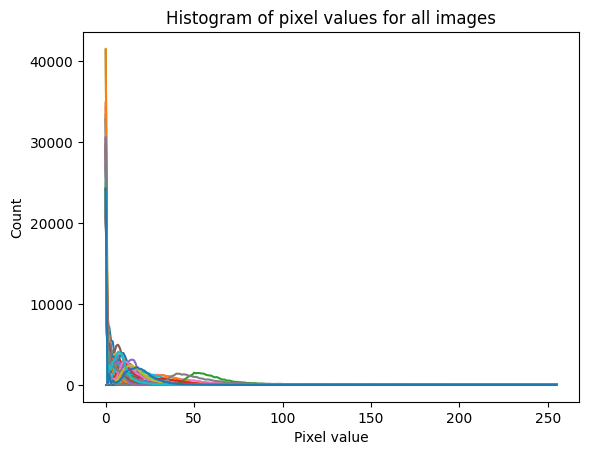

In [119]:
for filename in os.listdir(input_dir):
    img = cv2.imread(os.path.join(input_dir, filename))
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    plt.xlabel('Pixel value')
    plt.ylabel('Count')
    plt.title('Histogram of pixel values for all images')
    plt.plot(hist)
plt.savefig('Pixel values histogram')

In [120]:
# # Plotting pixel values of all images
# dir_path = "test_images"
# for filename in os.listdir(dir_path):
#     img = cv2.imread(os.path.join(dir_path, filename))
#     hist = cv2.calcHist([img], [0], None, [256], [0,256])
#     plt.xlabel('Pixel value')
#     plt.ylabel('Count')
#     plt.title('Histogram of pixel values for all images')
#     plt.plot(hist)
# plt.show()
# plt.savefig('Pixel values histogram')

In [121]:
# color = ('b','g','r')
# for filename in os.listdir(dir_path):
#     img = cv2.imread(os.path.join(dir_path, filename))
#     if img is not None:  # Add this check
#         for i,col in enumerate(color):
#             histr = cv2.calcHist([img],[i],None,[255],[1,255])
#             plt.plot(histr,color = col)
#             plt.xlim([1,256])
        
# plt.show()


In [122]:
# im01 = cv2.imread('test_images/im01-RET029OD.jpg', cv2.IMREAD_COLOR)

# # Convert the image to grayscale
# gray = cv2.cvtColor(im01, cv2.COLOR_RGB2GRAY)

# # Apply a threshold to create a binary image
# _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

# # Detect circles using the Hough transform
# circles = cv2.HoughCircles(thresh, cv2.HOUGH_GRADIENT, 1, minDist=50,
#                            param1=200, param2=20, minRadius=0, maxRadius=0)

# if circles is not None:
#     # Extract the coordinates and radius of the circle
#     x = int(circles[0][0][0])
#     y = int(circles[0][0][1])
#     r = int(circles[0][0][2])

#     # Draw a circle around the detected circle
#     cv2.circle(im01, (x, y), r, (0, 255, 0), 2)

#     # Display the image
#     cv2.imshow('image', im01)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

#     # Print the center coordinates and radius of the circle
#     print('Circle center:', (x, y))
#     print('Circle radius:', r)
# else:
#     print('No circles found in the image.')


In [123]:
#inpainting finally works!!!!!
processed_imgs = []
for img in [im05, im12, im27, im03]:
    mask = np.zeros_like(img[:,:,0])
    center = (188, 212)
    radius = 22
    cv2.circle(mask, center, radius, 255, -1)

    # Extract a similar section from the image
    section = img[120:160, 190:230]

    # Resize the mask to match the size of the image using interpolation
    mask_resized = cv2.resize(mask, img.shape[:2][::-1], interpolation=cv2.INTER_LANCZOS4)

    # Inpaint the corrupted region in the color image using the extracted section
    inpainted_color = cv2.inpaint(img, mask_resized, 3, cv2.INPAINT_TELEA)

    # Resize the section to match the size of the inpainted region
    section_resized = cv2.resize(section, inpainted_color.shape[:2][::-1], interpolation=cv2.INTER_LANCZOS4)

    # Replace the inpainted region with the extracted section
    processed_img = inpainted_color.copy()
    processed_img[mask_resized != 0] = section_resized[mask_resized != 0]

    # Append the processed image to the list
    processed_imgs.append(processed_img)


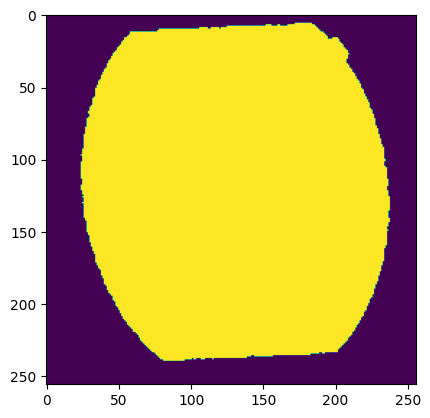

C:\Users\betht\AppData\Local\Temp\ipykernel_24068\626300188.py:20: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


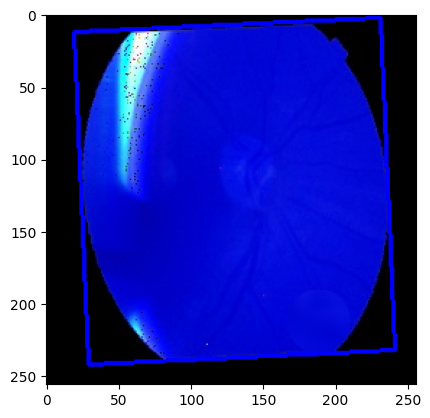

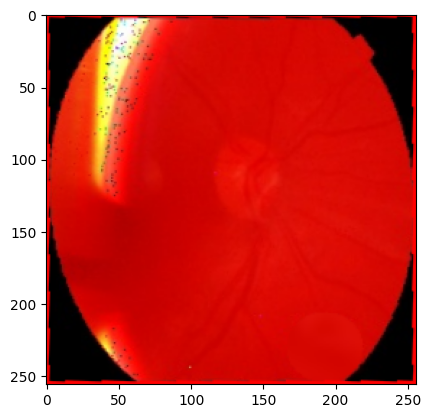

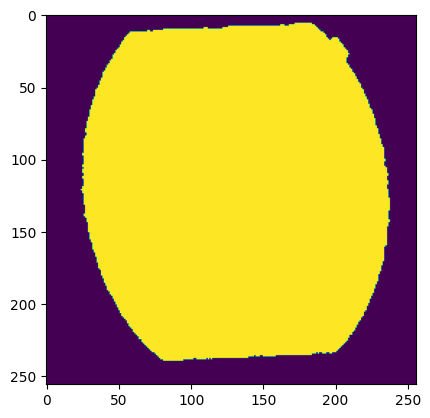

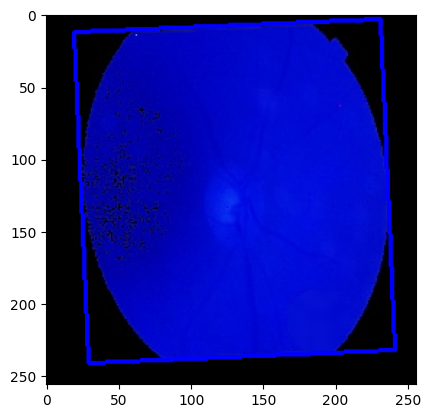

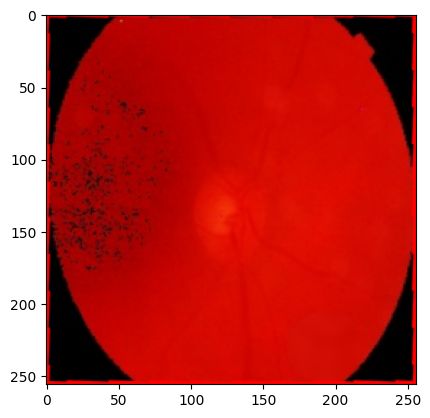

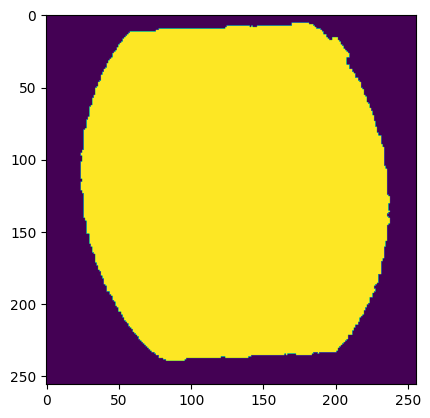

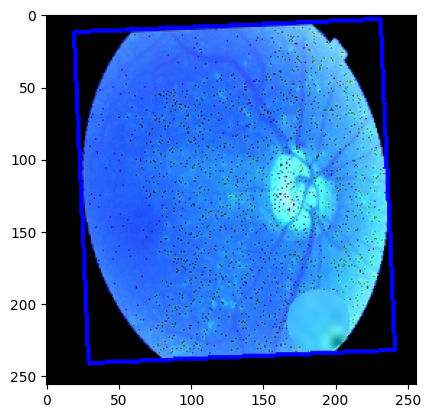

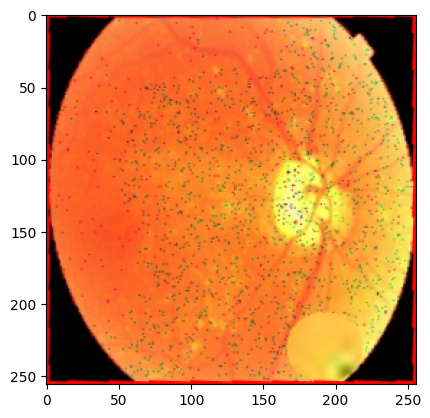

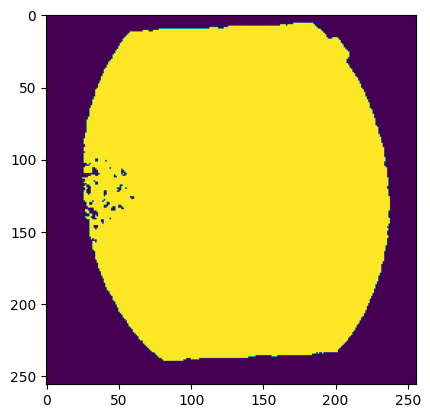

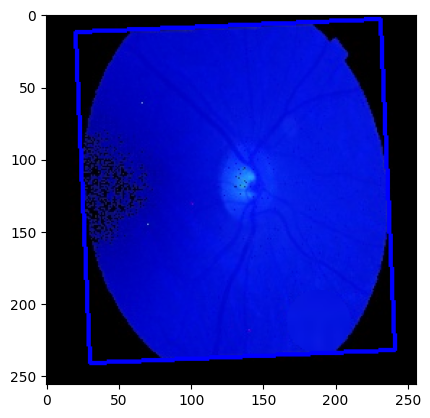

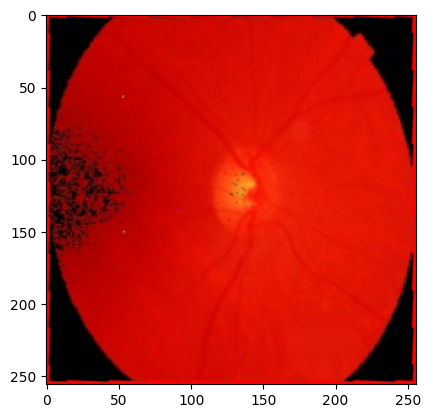

In [124]:
#dewarping and removing borders 1
dewarped = []
for img in processed_imgs:
    img=img
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 10, 255, 0)

    plt.imshow(thresh)
    plt.show()
    #dewarping and removing borders 2
    # finding the contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE,
                                cv2.CHAIN_APPROX_SIMPLE)
    
    # take the first contour
    cnt = contours[0]

    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    box_img = cv2.drawContours(img, [box], 0, (0, 0, 255), 2)

    # Show the result
    plt.imshow(box_img)
    plt.show()
    #dewarping and removing borders 3

    extent = np.float32([[0,0], [255,0], [255,255], [0,255]])
    bounds = np.float32(box)

    M = cv2.getPerspectiveTransform(bounds, extent)

    # Apply the transformation to the image
    result = cv2.warpPerspective(img, M, (256, 256))
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    # Show the result
    plt.imshow(result)
    plt.show()
    dewarped.append(result)

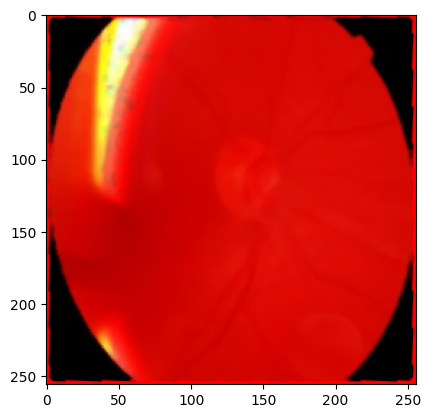

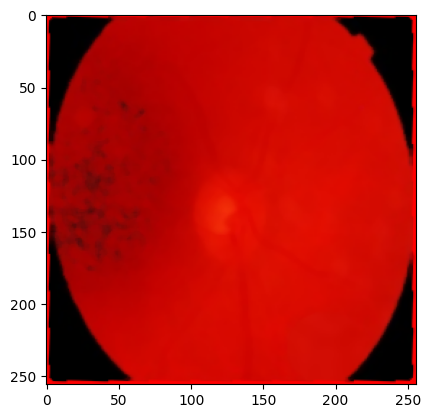

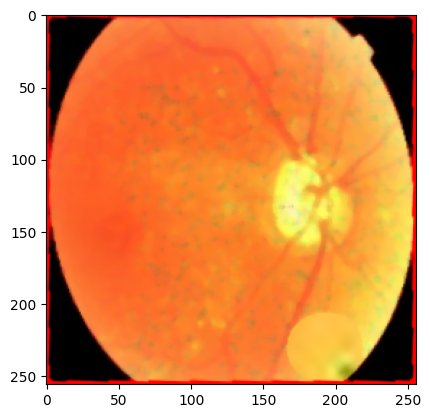

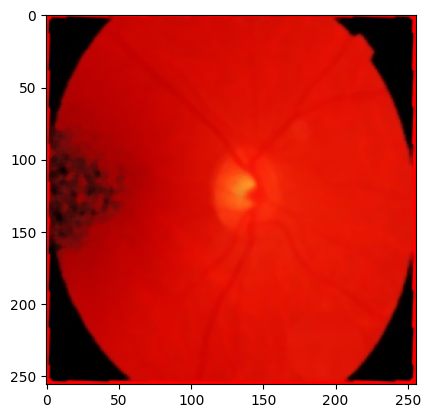

In [125]:
# median
median_list = []
for img in dewarped:
    median = cv2.medianBlur(img, 5)
    plt.imshow(median)
    plt.show()
    median_list.append(median)



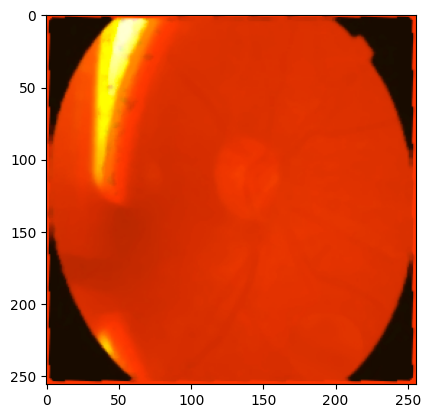

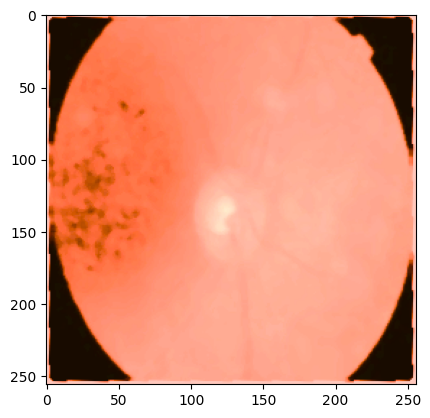

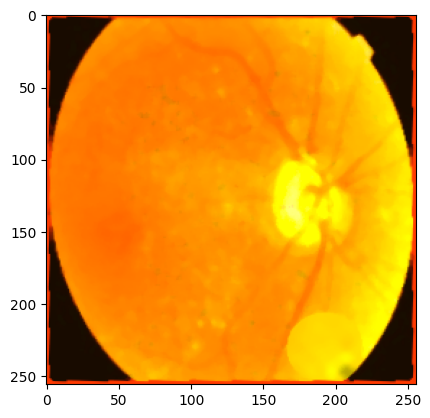

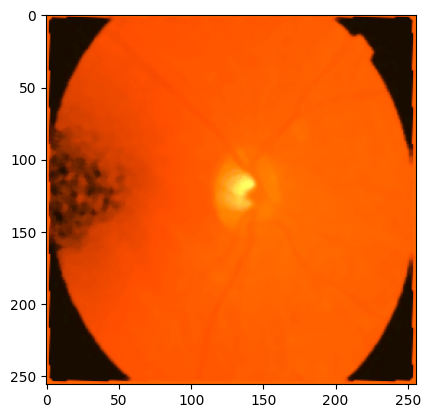

In [166]:
color_list = []
for img in median_list:
    # Convert the image to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Split the LAB image into separate channels
    l_channel, a_channel, b_channel = cv2.split(lab)

    # Normalize the L channel to increase contrast
    l_channel = cv2.normalize(l_channel, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Adjust the brightness of the A and B channels
    a_channel = cv2.addWeighted(a_channel, 0.9, np.mean(a_channel), 0, 0)
    b_channel = cv2.addWeighted(b_channel, 0.9, np.mean(b_channel), 0, 0)

    # Merge the channels back into a single LAB image
    lab = cv2.merge([l_channel, a_channel, b_channel])

    # Convert the LAB image back to BGR color space
    balanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Display the original and balanced images side-by-side
    plt.imshow(img)
    plt.imshow(balanced)
    plt.show()
    color_list.append(balanced)
   

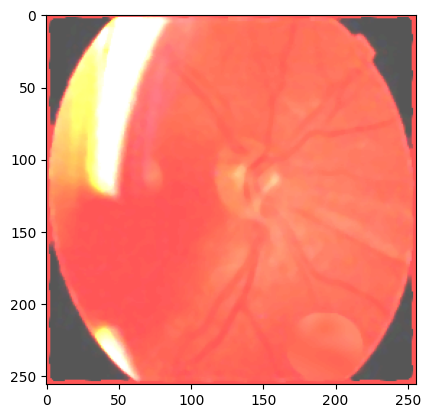

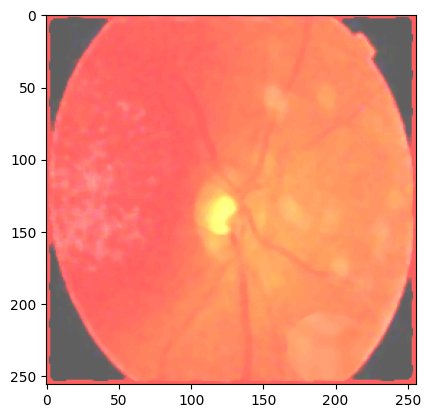

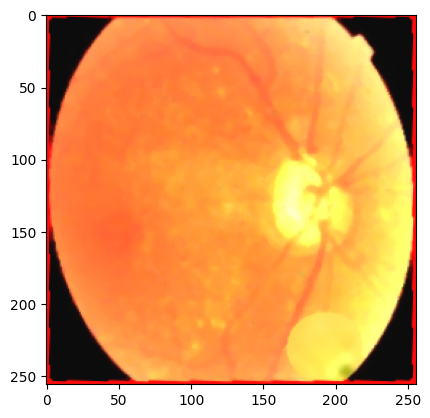

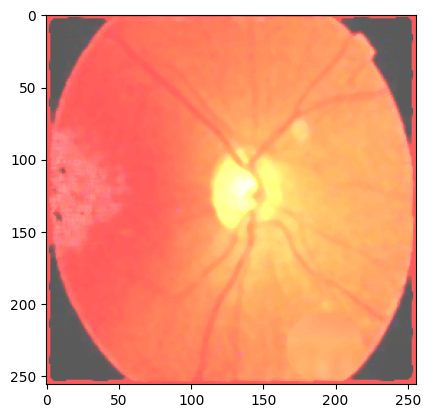

In [168]:
#MEAN PIXEL VALUE FOR BRIGHTNESS

#almost no need for colour changing- just ruining my results
# Define the directory containing the images

# Define the target mean pixel value
target_mean = 120

# Loop over all images in the directory
for img in median_list:
    # Load the image and convert to grayscale
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute the mean pixel value
    mean_pixel = np.mean(gray)

    # Compute the scale factor
    scale_factor = target_mean / mean_pixel
    difference = abs(target_mean- mean_pixel)
    # Adjust the contrast and brightness
    adjusted = cv2.convertScaleAbs(img, alpha=scale_factor, beta=difference)

    # Save the adjusted image
    plt.imshow(img)
    plt.imshow(adjusted)
    plt.show()



In [136]:
for img in median_list:
    # Increase the contrast and brightness
    alpha = 3 # Contrast control (1.0-3.0)
    beta = 50  # Brightness control (0-100)
    adjusted = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # Display the original and adjusted images side-by-side
    cv2.imshow('Original', img)
    cv2.imshow('Adjusted', adjusted)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [127]:
#nmeans for image 1 
nmeans_1 = cv2.fastNlMeansDenoisingColored(im01)
cv2.imwrite("nmeans_1.jpg", nmeans_1)

#Bilateral for image 1 
bilat_1 = cv2.bilateralFilter((im01),3,75,75)
cv2.imwrite("bilat_1.jpg", bilat_1)

#Gaussian on image 1 
gaussian_1 = cv2.GaussianBlur(im01, (3,3), 30)
cv2.imwrite("gaussian_1.jpg", gaussian_1)

#exp function
import math
def exponential_transform(image, c, alpha):
    for i in range(0, image.shape[1]):  # image width
        for j in range(0, image.shape[0]):  # image height

            # compute exponential transform

            image[j, i] = int(c * (math.pow(1 + alpha, image[j, i]) - 1))
    return image
scaled_1= cv2.resize(im01, ((int(im01.shape[1] * 0.6)),int(im01.shape[0] * 0.6)), interpolation=cv2.INTER_AREA)
gray_scaled_im01 = cv2.cvtColor(scaled_1, cv2.COLOR_BGR2GRAY)
EXP1 = exponential_transform(gray_scaled_im01, 130, 0.003)
colored_EXP1 = cv2.cvtColor(EXP1, cv2.COLOR_GRAY2BGR)
cv2.imwrite("EXPt1.png", colored_EXP1)

# gamma correction 
import numpy as np
gamma_1 = np.array(255*(1/255)**1.4,dtype='uint8')
cv2.imwrite("gamma_1.png", gamma_1)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\photo\src\denoising.cpp:178: error: (-5:Bad argument) Type of input image should be CV_8UC3 or CV_8UC4! in function 'cv::fastNlMeansDenoisingColored'
